In [4]:
# Get METAR data in bulk
%run auto_request_data.py

Enter airport ICAO code: RCSS
Enter end year: 2022
Enter end month: 3
Enter end day: 8
Enter end hour: 12
Enter time in months: 48
1 of 48 months retrieved
2 of 48 months retrieved
3 of 48 months retrieved
Pausing for 1 minute to prevent overloading...
4 of 48 months retrieved
5 of 48 months retrieved
6 of 48 months retrieved
Pausing for 1 minute to prevent overloading...
7 of 48 months retrieved
8 of 48 months retrieved
9 of 48 months retrieved
Pausing for 1 minute to prevent overloading...
10 of 48 months retrieved
11 of 48 months retrieved
12 of 48 months retrieved
Pausing for 1 minute to prevent overloading...
13 of 48 months retrieved
14 of 48 months retrieved
15 of 48 months retrieved
Pausing for 1 minute to prevent overloading...
16 of 48 months retrieved
17 of 48 months retrieved
18 of 48 months retrieved
Pausing for 1 minute to prevent overloading...
19 of 48 months retrieved
20 of 48 months retrieved
21 of 48 months retrieved
Pausing for 1 minute to prevent overloading...
22 

In [21]:
# Parse relevant METAR data into CSV
%run parse_to_csv.py RCSS

RCSS


In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.8.0


In [3]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.2f}".format

In [4]:
airport = "RCTP"

train_df = pd.read_csv(airport + "/" + airport + "_train.csv")
test_df = pd.read_csv(airport + "/" + airport + "_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

print(train_df)

       month  windSpdKts  gustKts  windVrbDeg  intensity  rain  \
16533      4           8        0           0       0.00     0   
16277      6           4        0           0       0.00     0   
3481      11          15        0           0       0.30     1   
31818      8           6        0          90       0.30     1   
14738      7          15        0           0       0.00     0   
...      ...         ...      ...         ...        ...   ...   
5107       8          11        0           0       0.00     0   
11130     12          22       33           0       0.30     1   
2105      12          19        0           0       0.30     1   
18163      3           4        0         130       0.00     0   
13426      8          15        0           0       0.00     0   

       visibilityMtrs   qnh  ws  
16533            9999  1016   0  
16277            9999  1012   0  
3481             5000  1019   0  
31818            9999  1008   0  
14738            9999  1007   0  
...

In [5]:
train_df_norm = train_df.copy()
test_df_norm = test_df.copy()

# Scale down wind speed
train_df_norm["windSpdKts"] /= 50
test_df_norm["windSpdKts"] /= 50

# Scale down wind gust speed
train_df_norm["gustKts"] /= 50
test_df_norm["gustKts"] /= 50

# Scale down wind variability
train_df_norm["windVrbDeg"] /= 100
test_df_norm["windVrbDeg"] /= 100

# Scale down visibility
# train_df_norm["visibilityMtrs"] /= 10000
# test_df_norm["visibilityMtrs"] /= 10000

# Normalise, scale down QNH
train_df_norm["qnh"] -= 1013
train_df_norm["qnh"] /= 10
test_df_norm["qnh"] -= 1013
test_df_norm["qnh"] /= 10

print(train_df_norm)
print(test_df_norm)

       month  windSpdKts  gustKts  windVrbDeg  intensity  rain  \
16533      4        0.16     0.00        0.00       0.00     0   
16277      6        0.08     0.00        0.00       0.00     0   
3481      11        0.30     0.00        0.00       0.30     1   
31818      8        0.12     0.00        0.90       0.30     1   
14738      7        0.30     0.00        0.00       0.00     0   
...      ...         ...      ...         ...        ...   ...   
5107       8        0.22     0.00        0.00       0.00     0   
11130     12        0.44     0.66        0.00       0.30     1   
2105      12        0.38     0.00        0.00       0.30     1   
18163      3        0.08     0.00        1.30       0.00     0   
13426      8        0.30     0.00        0.00       0.00     0   

       visibilityMtrs   qnh  ws  
16533            9999  0.30   0  
16277            9999 -0.10   0  
3481             5000  0.60   0  
31818            9999 -0.50   0  
14738            9999 -0.60   0  
...

In [27]:
feature_columns = []

month_boundaries = list(np.arange(1, 13))
month = tf.feature_column.numeric_column("month")
monthBin = tf.feature_column.bucketized_column(month, month_boundaries)
feature_columns.append(monthBin)
# print(monthBin)

windSpdKts = tf.feature_column.numeric_column("windSpdKts")
feature_columns.append(windSpdKts)

gustKts = tf.feature_column.numeric_column("gustKts")
feature_columns.append(gustKts)

windVrbDeg = tf.feature_column.numeric_column("windVrbDeg")
feature_columns.append(windVrbDeg)

intensity = tf.feature_column.numeric_column("intensity")
feature_columns.append(intensity)

rain = tf.feature_column.numeric_column("rain")
feature_columns.append(rain)

vis_boundaries = list(np.arange(-1, 10000, 1000))
visibilityMtrs = tf.feature_column.numeric_column("visibilityMtrs")
visibilityMtrsBin = tf.feature_column.bucketized_column(visibilityMtrs, vis_boundaries)
feature_columns.append(visibilityMtrsBin)
# print(visibilityMtrsBin)

qnh = tf.feature_column.numeric_column("qnh")
feature_columns.append(qnh)

# Create a feature cross of windSpdKts and windVrbDeg
spd_x_vrb = tf.feature_column.crossed_column(["windSpdKts", "windVrbDeg"], hash_bucket_size=1000)
crossed_spd_vrb = tf.feature_column.indicator_column(spd_x_vrb)
feature_columns.append(crossed_spd_vrb)

# Create a feature cross of intensity and rain
int_x_rain = tf.feature_column.crossed_column(["intensity", "rain"], hash_bucket_size=50)
crossed_int_rain = tf.feature_column.indicator_column(int_x_rain)
feature_columns.append(crossed_int_rain)

feature_layer = layers.DenseFeatures(feature_columns)

# np.set_printoptions(threshold=False)
# print(train_df_norm[train_df_norm.visibilityMtrs == train_df_norm.visibilityMtrs.min()])
# print(feature_layer(dict(train_df_norm)))

In [28]:
def neural_model(my_learning_rate, feature_layer, my_metrics, initial_bias=None):
    """Create and compile a simple classification model."""
    model = tf.keras.models.Sequential()
    
    if initial_bias is not None:
        initial_bias = tf.keras.initializers.Constant(initial_bias)
    
    model.add(feature_layer)

    # Funnel the regression value through a ReLU function.
    model.add(tf.keras.layers.Dense(units=40, activation='relu', name="hidden1",
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
    
    # model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(units=20, activation='relu', name="hidden2",
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
    
    # model.add(tf.keras.layers.Dropout(0.2))
    
    # Define the output layer.
    model.add(tf.keras.layers.Dense(units=1, name='Output', activation='sigmoid', bias_initializer=initial_bias))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  Notice that we're using a different loss
    # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),                                                   
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=my_metrics)

    return model


def linear_model(my_learning_rate, feature_layer, my_metrics, initial_bias=None):
    """Create and compile a simple classification model."""
    model = tf.keras.models.Sequential()
    
    if initial_bias is not None:
        initial_bias = tf.keras.initializers.Constant(initial_bias)
    
    model.add(feature_layer)

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(20,), activation='sigmoid', bias_initializer=initial_bias))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  Notice that we're using a different loss
    # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),                                                   
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=my_metrics)

    return model   


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True, validation_split=0.2):
    """Feed a dataset into the model in order to train it."""

    # The x parameter of tf.keras.Model.fit can be a list of arrays, where
    # each array contains the data for one feature.  Here, we're passing
    # every column in the dataset. Note that the feature_layer will filter
    # away most of those columns, leaving only the desired columns and their
    # representations as features.
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name)) 
    history = model.fit(x=features, y=label, batch_size=batch_size,
                          epochs=epochs, shuffle=shuffle, validation_split=validation_split)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the classification metric for each epoch.
    hist = pd.DataFrame(history.history)

    return epochs, hist

print("Defined the 2 models and train_model functions.")

Defined the 2 models and train_model functions.


In [29]:
def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""   

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


In [30]:
def get_initial_bias(train_set):
    pos_count = len(train_set[train_set.ws == 1])
    neg_count = train_set.size - pos_count
    return np.log([pos_count / neg_count])

Epoch 1/35
251/251 [==============================] - 2s 4ms/step - loss: 0.2837 - t-pos: 61.0000 - f-pos: 13.0000 - t-neg: 22603.0000 - f-neg: 2394.0000 - accuracy: 0.9043 - precision: 0.8161 - recall: 0.0289 - roc-auc: 0.7461 - pr-auc: 0.3219 - val_loss: 0.2619 - val_t-pos: 53.0000 - val_f-pos: 16.0000 - val_t-neg: 9656.0000 - val_f-neg: 1021.0000 - val_accuracy: 0.9033 - val_precision: 0.7108 - val_recall: 0.0549 - val_roc-auc: 0.8349 - val_pr-auc: 0.4158
Epoch 2/35
251/251 [==============================] - 0s 2ms/step - loss: 0.2440 - t-pos: 289.0000 - f-pos: 107.0000 - t-neg: 22509.0000 - f-neg: 2166.0000 - accuracy: 0.9108 - precision: 0.7088 - recall: 0.1507 - roc-auc: 0.8564 - pr-auc: 0.4557 - val_loss: 0.2444 - val_t-pos: 203.0000 - val_f-pos: 79.0000 - val_t-neg: 9593.0000 - val_f-neg: 871.0000 - val_accuracy: 0.9108 - val_precision: 0.6706 - val_recall: 0.2104 - val_roc-auc: 0.8546 - val_pr-auc: 0.4591
Epoch 3/35
251/251 [==============================] - 0s 2ms/step - loss

251/251 [==============================] - 0s 2ms/step - loss: 0.2002 - t-pos: 708.0000 - f-pos: 302.0000 - t-neg: 22314.0000 - f-neg: 1747.0000 - accuracy: 0.9191 - precision: 0.6735 - recall: 0.3369 - roc-auc: 0.9101 - pr-auc: 0.5704 - val_loss: 0.2063 - val_t-pos: 320.0000 - val_f-pos: 143.0000 - val_t-neg: 9529.0000 - val_f-neg: 754.0000 - val_accuracy: 0.9160 - val_precision: 0.6503 - val_recall: 0.3445 - val_roc-auc: 0.9041 - val_pr-auc: 0.5622
Epoch 14/35
251/251 [==============================] - 0s 2ms/step - loss: 0.1992 - t-pos: 740.0000 - f-pos: 318.0000 - t-neg: 22298.0000 - f-neg: 1715.0000 - accuracy: 0.9196 - precision: 0.6703 - recall: 0.3519 - roc-auc: 0.9109 - pr-auc: 0.5718 - val_loss: 0.2053 - val_t-pos: 322.0000 - val_f-pos: 136.0000 - val_t-neg: 9536.0000 - val_f-neg: 752.0000 - val_accuracy: 0.9157 - val_precision: 0.6500 - val_recall: 0.3389 - val_roc-auc: 0.9046 - val_pr-auc: 0.5676
Epoch 15/35
251/251 [==============================] - 0s 2ms/step - loss: 0.1

Epoch 31/35
251/251 [==============================] - 0s 2ms/step - loss: 0.1964 - t-pos: 843.0000 - f-pos: 395.0000 - t-neg: 22221.0000 - f-neg: 1612.0000 - accuracy: 0.9193 - precision: 0.6446 - recall: 0.3923 - roc-auc: 0.9115 - pr-auc: 0.5774 - val_loss: 0.2038 - val_t-pos: 410.0000 - val_f-pos: 241.0000 - val_t-neg: 9431.0000 - val_f-neg: 664.0000 - val_accuracy: 0.9139 - val_precision: 0.5944 - val_recall: 0.4367 - val_roc-auc: 0.9063 - val_pr-auc: 0.5731
Epoch 32/35
251/251 [==============================] - 0s 2ms/step - loss: 0.1964 - t-pos: 869.0000 - f-pos: 424.0000 - t-neg: 22192.0000 - f-neg: 1586.0000 - accuracy: 0.9190 - precision: 0.6386 - recall: 0.3988 - roc-auc: 0.9111 - pr-auc: 0.5770 - val_loss: 0.2030 - val_t-pos: 379.0000 - val_f-pos: 206.0000 - val_t-neg: 9466.0000 - val_f-neg: 695.0000 - val_accuracy: 0.9155 - val_precision: 0.6203 - val_recall: 0.3985 - val_roc-auc: 0.9058 - val_pr-auc: 0.5695
Epoch 33/35
251/251 [==============================] - 0s 2ms/step

[0.1990504115819931,
 505.0,
 252.0,
 13607.0,
 1003.0,
 0.9170299768447876,
 0.6301676034927368,
 0.3740053176879883,
 0.9087218046188354,
 0.568147599697113]

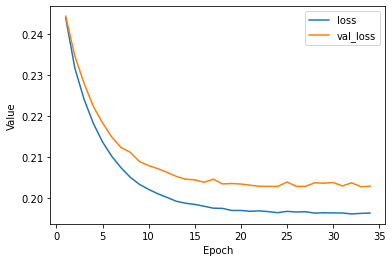

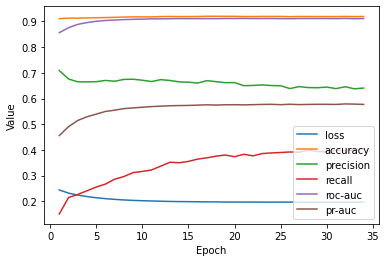

In [31]:
learning_rate = 0.01
epochs = 35
batch_size = 100
label_name = "ws"
classification_threshold = 0.45
validation_split = 0.3
initial_bias = get_initial_bias(train_df_norm)

# Establish the metrics the model will measure.
METRICS = [
    tf.keras.metrics.TruePositives(name='t-pos'),
    tf.keras.metrics.FalsePositives(name='f-pos'),
    tf.keras.metrics.TrueNegatives(name='t-neg'),
    tf.keras.metrics.FalseNegatives(name='f-neg'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold,name='precision'),
    tf.keras.metrics.Recall(thresholds=classification_threshold,name='recall'),
    tf.keras.metrics.AUC(num_thresholds=100, name='roc-auc'),
    tf.keras.metrics.AUC(num_thresholds=100, name='pr-auc', curve='PR')
]

# Establish the model's topography.
my_model = linear_model(learning_rate, feature_layer, METRICS, initial_bias=initial_bias)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size, validation_split=validation_split)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot_1 = ['loss', 'val_loss']
list_of_metrics_to_plot_2 = ['loss', 'accuracy', 'precision', 'recall', 'roc-auc', 'pr-auc']

plot_curve(epochs, hist, list_of_metrics_to_plot_1)
plot_curve(epochs, hist, list_of_metrics_to_plot_2)

x_test = {name: np.array(value) for name, value in test_df_norm.items()}
y_test = np.array(x_test.pop(label_name))

my_model.evaluate(x_test, y_test, batch_size=batch_size)